In [1]:
import tensorflow as tf
import numpy as np
import random
import matplotlib.pyplot as plt

from zipfile import ZipFile

In [2]:
with ZipFile("archive.zip","r") as zip:
    zip.extractall()

In [3]:
random.seed(123)
np.random.seed(123)
tf.random.set_seed(123)

In [4]:
batch_size = 32
img_size = (100,100)

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "train/train",
    validation_split = 0.2,
    subset = "training",
    seed = 123,
    image_size = img_size,
    batch_size = batch_size,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "train/train",
    validation_split = 0.2,
    subset = "validation",
    seed = 123,
    image_size = img_size,
    batch_size = batch_size,
)

val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches//5)
val_ds = val_ds.skip(val_batches//5)

Found 16854 files belonging to 33 classes.
Using 13484 files for training.
Found 16854 files belonging to 33 classes.
Using 3370 files for validation.


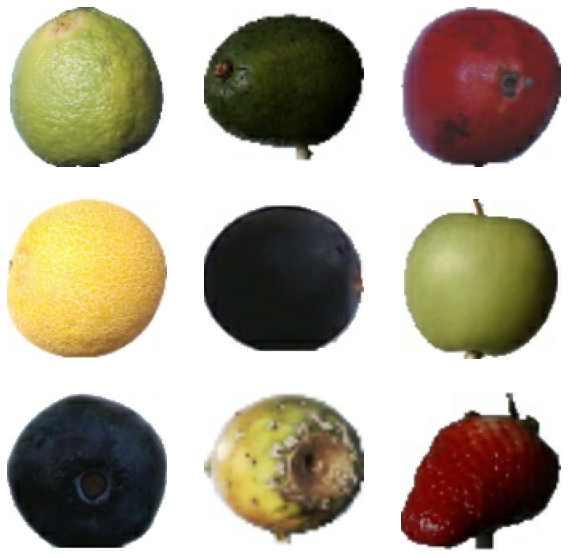

In [5]:
plt.figure(figsize=(10,10))
for images,_ in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")
plt.show()

In [6]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

### Data Augmentation

In [7]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
])

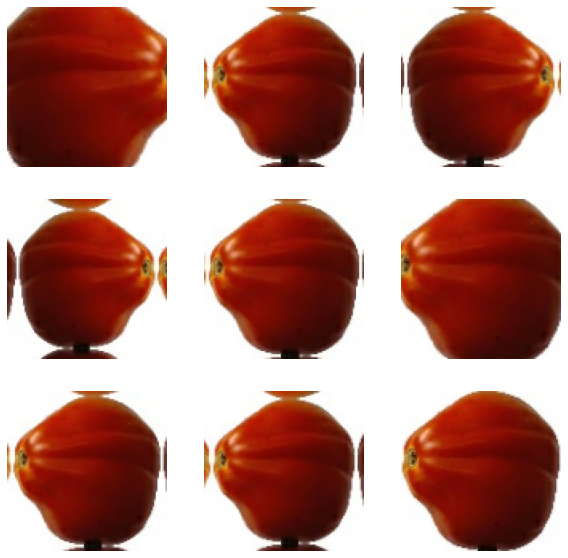

In [8]:
plt.figure(figsize=(10,10))
for images,_ in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        augmented_images = data_augmentation(images)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")
plt.show()

### Build the model

In [9]:
input_shape = img_size+(3,)
preprocess_input = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

def model():
    inputs = tf.keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = preprocess_input(x)
    x = tf.keras.layers.Conv2D(64,5,activation="relu",padding="same",strides=(2,2))(x)
    x = tf.keras.layers.Conv2D(64,5,activation="relu",padding="same",strides=(2,2))(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Dropout(0.25,seed=123)(x)
    x = tf.keras.layers.Conv2D(128,5,activation="relu",padding="same",strides=(2,2))(x)
    x = tf.keras.layers.Conv2D(128,5,activation="relu",padding="same",strides=(2,2))(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256,activation="relu")(x)
    x = tf.keras.layers.Dropout(0.5,seed=123)(x)
    outputs = tf.keras.layers.Dense(33,activation="softmax")(x)
    model = tf.keras.Model(inputs,outputs)
    return model

model = model()
model.summary()
model.compile(tf.keras.optimizers.Adam(learning_rate=0.0001),tf.keras.losses.SparseCategoricalCrossentropy(),metrics=["accuracy"])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 100, 100, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 100, 100, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 50, 50, 64)        4864      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 25, 25, 64)        102464    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 64)        0     

### Train and evaluate the model

In [10]:
if __name__=="__main__":
    epochs = 8
    loss0,accuracy0 = model.evaluate(val_ds)
    checkpoint = tf.keras.callbacks.ModelCheckpoint("fruit.h5",save_weights_only=False,monitor="val_accuracy",save_best_only=True)
    model.fit(train_ds,epochs=epochs,validation_data=val_ds,callbacks=[checkpoint])
    best = tf.keras.models.load_model("fruit.h5")
    loss,accuracy = best.evaluate(test_ds)
    print("\nAccuracy: {:.2f} %".format(100*accuracy))
    print("Loss: {:.2f} %".format(100*loss))

85/85 [==============================] - 2s 6ms/step - loss: 3.5006 - accuracy: 0.0248
Epoch 1/8
422/422 [==============================] - 8s 18ms/step - loss: 2.3669 - accuracy: 0.2932 - val_loss: 0.7676 - val_accuracy: 0.8373
Epoch 2/8
422/422 [==============================] - 8s 18ms/step - loss: 0.8848 - accuracy: 0.7039 - val_loss: 0.2095 - val_accuracy: 0.9485
Epoch 3/8
422/422 [==============================] - 8s 18ms/step - loss: 0.4154 - accuracy: 0.8588 - val_loss: 0.0734 - val_accuracy: 0.9841
Epoch 4/8
422/422 [==============================] - 8s 18ms/step - loss: 0.2674 - accuracy: 0.9097 - val_loss: 0.0485 - val_accuracy: 0.9855
Epoch 5/8
422/422 [==============================] - 8s 19ms/step - loss: 0.1814 - accuracy: 0.9389 - val_loss: 0.0276 - val_accuracy: 0.9941
Epoch 6/8
422/422 [==============================] - 8s 18ms/step - loss: 0.1423 - accuracy: 0.9539 - val_loss: 0.0213 - val_accuracy: 0.9952
Epoch 7/8
422/422 [==============================] - 8s 18ms/